Set the work envarioment

In [9]:
import os
import sys
from dotenv import load_dotenv

load_dotenv()
work_dir = os.getenv("WORK_DIR")

sys.path.append(work_dir)


Libreries and modules

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import inspect
from sqlalchemy.orm import sessionmaker, aliased
from src.database.db_connection import get_engine
from src.models.SteamGames_models import Games, SteamGames
from wordcloud import WordCloud

Connection and sessions

In [11]:
connection = get_engine()

Session = sessionmaker(bind=connection)
session = Session()

Conected successfully to database PruebaCarga!


Called to table

In [12]:
table = aliased(Games)
query = session.query(table).statement
games = pd.read_sql(query, connection)

## EDA

To obtain information about the games.

In [13]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85103 entries, 0 to 85102
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AppID                    85103 non-null  int64  
 1   Name                     85097 non-null  object 
 2   ReleaseDate              85103 non-null  object 
 3   EstimatedOwners          85103 non-null  object 
 4   PeakCCU                  85103 non-null  int64  
 5   RequiredAge              85103 non-null  int64  
 6   Price                    85103 non-null  float64
 7   DLCCount                 85103 non-null  int64  
 8   AboutTheGame             81536 non-null  object 
 9   SupportedLanguages       85103 non-null  object 
 10  FullAudioLanguages       85103 non-null  object 
 11  Reviews                  9743 non-null   object 
 12  HeaderImage              85103 non-null  object 
 13  Website                  39452 non-null  object 
 14  SupportUrl            

Create a dictionary 'games_summary' with summary information about the DataFrame 'games'. With this information: Data types of each column, Number of missing values per column, Number of rows in the DataFrame.

In [14]:
games_summary = {
    'types': games.dtypes,
    'missing': games.isna().sum(),
    'size': games.shape[0],
}

print(pd.DataFrame(games_summary))

                           types  missing   size
AppID                      int64        0  85103
Name                      object        6  85103
ReleaseDate               object        0  85103
EstimatedOwners           object        0  85103
PeakCCU                    int64        0  85103
RequiredAge                int64        0  85103
Price                    float64        0  85103
DLCCount                   int64        0  85103
AboutTheGame              object     3567  85103
SupportedLanguages        object        0  85103
FullAudioLanguages        object        0  85103
Reviews                   object    75360  85103
HeaderImage               object        0  85103
Website                   object    45651  85103
SupportUrl                object    43517  85103
SupportEmail              object    13596  85103
Windows                     bool        0  85103
Mac                         bool        0  85103
Linux                       bool        0  85103
MetacriticScore     

**_Data Types:_**

The dataset includes a mix of data types, such as integers (int64), floating-point numbers (float64), objects (likely strings or mixed types), and boolean values (bool).  

**_Missing Values:_**

Several columns have missing values, with the highest number in the "Reviews," "SupportUrl," "Website," and "MetacriticUrl" columns.
The "Name" column has six missing values, and "AboutTheGame" has 3,567 missing values.

Bar chart using seaborn to show the count of data types in the dataset

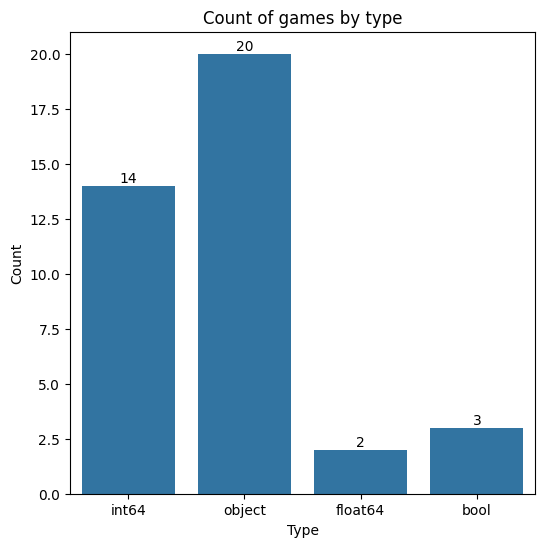

In [15]:
plt.figure(figsize=(6, 6))
ax = sns.countplot(x='types', data=games_summary)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Count of games by type')
plt.xlabel('Type')
plt.ylabel('Count')

plt.show()

## Columns transformation

Drop columns that we are not going to use because they are not suitable for the type of analytics we want to do.

In [16]:
drop_columns = ['ScoreRank', 'Reviews', 'HeaderImage', 'Website', 'SupportUrl', 'SupportEmail', 'MetacriticUrl', 'Screenshots', 'Movies', 'AboutTheGame', 'Notes']
games = games.drop(drop_columns, axis=1)

## Clean columns 

Delete rows with NaN values in the 'Name' column, because there are only 6 values, and it is not useful to have data from a game whose name is not known.

In [17]:
games = games.drop(games.loc[games['Name'].isna()].index)
games.isna().sum()

AppID                          0
Name                           0
ReleaseDate                    0
EstimatedOwners                0
PeakCCU                        0
RequiredAge                    0
Price                          0
DLCCount                       0
SupportedLanguages             0
FullAudioLanguages             0
Windows                        0
Mac                            0
Linux                          0
MetacriticScore                0
UserScore                      0
Positive                       0
Negative                       0
Achievements                   0
Recommendations                0
AveragePlaytimeForever         0
AveragePlaytimeTwoWeeks        0
MedianPlaytimeForever          0
MedianPlaytimeTwoWeeks         0
Developers                  3581
Publishers                  3861
Categories                  4595
Genres                      3553
Tags                       21094
dtype: int64

Fill missing values in specific columns ('Developers', 'Publishers', 'Categories', 'Genres', 'Tags') with 'Others'. So as not to discard the information

In [18]:
games['Developers'] = games['Developers'].fillna('Others')
games['Publishers'] = games['Publishers'].fillna('Others')
games['Categories'] = games['Categories'].fillna('Others')
games['Genres'] = games['Genres'].fillna('Others')
games['Tags'] = games['Tags'].fillna('Others')

Show the number of missing values after deleting and filling rows, and we can see that there are no more nulls in any of the columns

In [19]:
games.isnull().sum()

AppID                      0
Name                       0
ReleaseDate                0
EstimatedOwners            0
PeakCCU                    0
RequiredAge                0
Price                      0
DLCCount                   0
SupportedLanguages         0
FullAudioLanguages         0
Windows                    0
Mac                        0
Linux                      0
MetacriticScore            0
UserScore                  0
Positive                   0
Negative                   0
Achievements               0
Recommendations            0
AveragePlaytimeForever     0
AveragePlaytimeTwoWeeks    0
MedianPlaytimeForever      0
MedianPlaytimeTwoWeeks     0
Developers                 0
Publishers                 0
Categories                 0
Genres                     0
Tags                       0
dtype: int64

## Data Visualization

Histogram showing the distribution of games released over the years, and convert the 'ReleaseDate' column to date and time format. With this graph you can see the relationship of game releases over time, and draw possible conclusions about it.

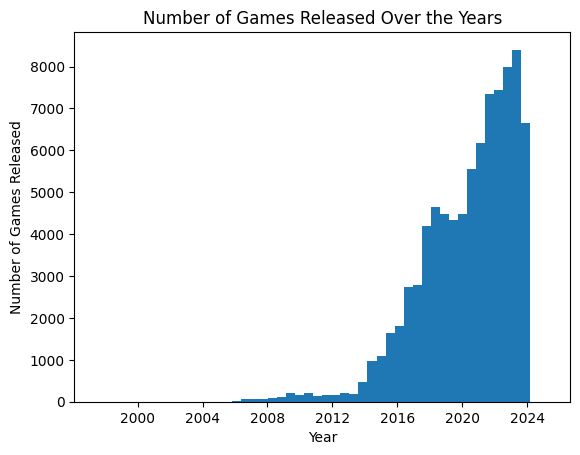

In [20]:
games['ReleaseDate'] = pd.to_datetime(games['ReleaseDate'], format='mixed')

plt.hist(games['ReleaseDate'], bins=50)
plt.xlabel('Year')
plt.ylabel('Number of Games Released')
plt.title('Number of Games Released Over the Years')
plt.show()

We can see that from the 2000s until 2013 or so developers almost didn't release games that frequently, but from 2014 until 2023 there are quite a few releases every year.
Developers are releasing games more frequently but these have shorter development time  

**¿Do these games still have the quality that will satisfy users?**

## Histogram 

Showing the price distribution of the games, showing whether or not price is a significant variable in the games

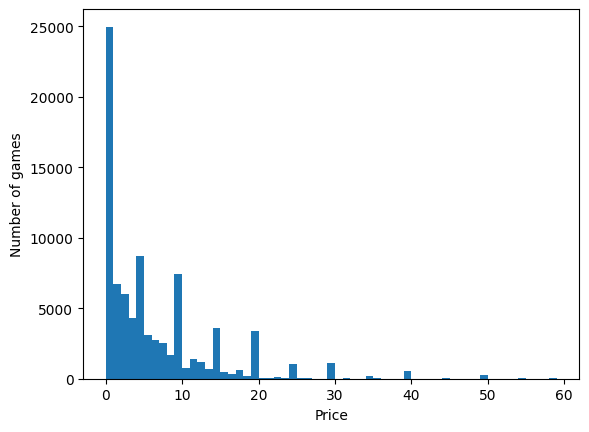

In [21]:
plt.hist(games['Price'], bins=list(range(0, 60)))
plt.xlabel('Price')
plt.ylabel('Number of games')
plt.show()

Most of the games in the dataset are free or their price is between 10 to 20 dollars, unfortunately we do not have information on whether the free games have transactions included in the game.

## Visualitation Most Downloades Games
1. Define a function called 'clean_ownership_range' to clean the ownership range in the 'EstimatedOwners' column.
2. Remove whitespace around the range.
3. Split the range into lower and upper values, and convert them to integers.
4. Calculate the middle value of the range.
5. Apply the 'clean_ownership_range' function to the 'EstimatedOwners' column and create a new column called 'OwnersClean'.

In [22]:
def clean_ownership_range(x):
    x = x.strip()
    lower, upper = map(int, x.split("-"))
    median = (upper - lower) / 2
    return median

games['OwnersClean'] = games['EstimatedOwners'].apply(clean_ownership_range)

1. Group the DataFrame 'games' by the name of the game.
2. Calculate the total sum of owners ('OwnersClean') for each game.
3. Reset the indexes of the resulting DataFrame.
4. Sort the DataFrame in descending order according to the 'OwnersClean' column.

In [23]:
most_downloaded_games = (
    games.groupby("Name")
    .agg({"OwnersClean": "sum"})
    .reset_index()
    .sort_values("OwnersClean", ascending=False)
    .head(10)
)

It performs the cleaning, manipulation and analysis of game data, and displays the graph of the most downloaded games in a bar chart.

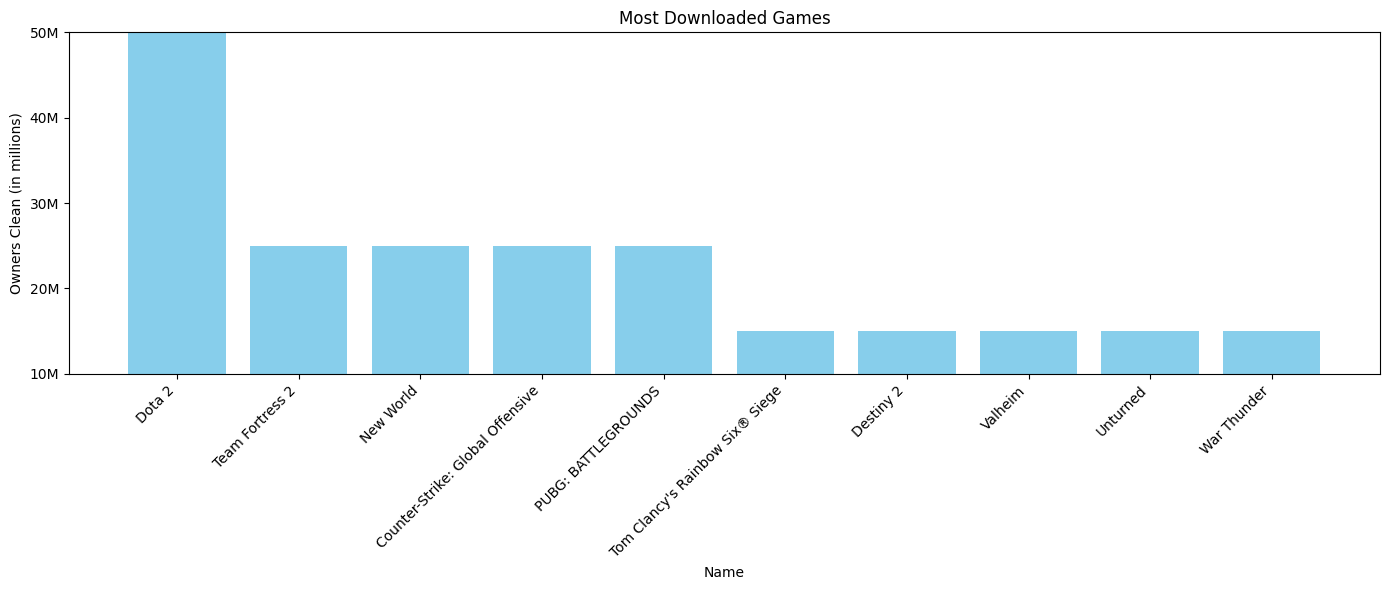

In [24]:
most_downloaded_games['Name'] = most_downloaded_games['Name'].fillna('')

games_sorted = most_downloaded_games.sort_values(by='OwnersClean', ascending=False)

filtered_games = games_sorted[(games_sorted['OwnersClean'] >= 10_000_000) & (games_sorted['OwnersClean'] <= 50_000_000)]

plt.figure(figsize=(14, 6))
bars = plt.bar(filtered_games['Name'], filtered_games['OwnersClean'], color='skyblue')
plt.title('Most Downloaded Games')
plt.xlabel('Name')
plt.ylabel('Owners Clean (in millions)')

plt.ylim(10_000_000, 50_000_000)  # Establecer límites del eje y
plt.yticks([10_000_000, 20_000_000, 30_000_000, 40_000_000, 50_000_000], ['10M', '20M', '30M', '40M', '50M'])

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The most downloaded game in our dataset is **Dota 2** which is currently free with approximately 50,000,000 downloads.

## New Column about Operative System 'OS'
Adds an 'OS' column to the 'games' DataFrame, indicating the supported operating systems for each game, and displays the first row of the resulting DataFrame with the updated information.

In [25]:
def determine_os(row):
    os_list = []
    if row['Windows']:
        os_list.append('Windows')
    if row['Mac']:
        os_list.append('Mac')
    if row['Linux']:
        os_list.append('Linux')
    return ', '.join(os_list)

games['OS'] = games.apply(determine_os, axis=1)

games.head(1)

,AppID,Name,ReleaseDate,EstimatedOwners,PeakCCU,RequiredAge,Price,DLCCount,SupportedLanguages,FullAudioLanguages,...,AveragePlaytimeTwoWeeks,MedianPlaytimeForever,MedianPlaytimeTwoWeeks,Developers,Publishers,Categories,Genres,Tags,OwnersClean,OS
0,20200,Galactic Bowling,2008-10-21,0 - 20000,0,0,19.99,0,['English'],[],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",10000.0,Windows


Performs an analysis by grouping the 'games' DataFrame by the 'OS' column and calculating the average of the 'OwnersClean' column for each group.

In [26]:
downloads_for_os = games.groupby('OS')['OwnersClean'].mean().reset_index()

print(downloads_for_os)

                    OS   OwnersClean
0                Linux   9000.000000
1                  Mac  11041.666667
2           Mac, Linux  25000.000000
3              Windows  28530.074392
4       Windows, Linux  37517.550702
5         Windows, Mac  43457.762852
6  Windows, Mac, Linux  88390.144928


Graph showing the number of downloads by operating system, where it can be seen that the sum of the 3 operating systems 'Mac', 'Linux' and 'Windows' has the largest number of downloads. 

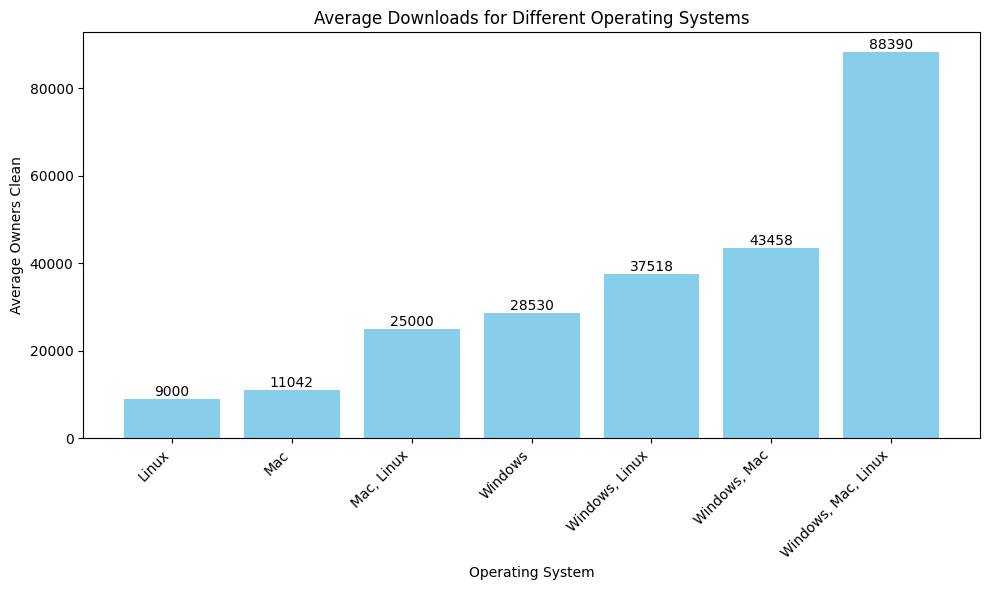

In [27]:
plt.figure(figsize=(10, 6))
bars = plt.bar(downloads_for_os['OS'], downloads_for_os['OwnersClean'], color='skyblue')
plt.title('Average Downloads for Different Operating Systems')
plt.xlabel('Operating System')
plt.ylabel('Average Owners Clean')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(round(yval)), ha='center', va='bottom', color='black', size=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This graph could indicate that the games released for the three operating systems have more downloads together, it is important to take into account the user segment and operating system to which the application will be released.

## Graph Top 10 Most Expensive Games

Provide information on the most expensive games in terms of the total sum of prices and displays them

In [28]:
most_expensive_games = games.groupby('Name')['Price'].sum().reset_index().sort_values('Price', ascending=False).head(10)

print(most_expensive_games)

                                                    Name   Price
70121                 The Leverage Game Business Edition  999.98
70120                                  The Leverage Game  999.98
4824                   Ascent Free-Roaming VR Experience  999.00
1786                               Aartform Curvy 3D 3.0  299.90
20872                                   EA SPORTS FC™ 24  279.96
32897                                      Houdini Indie  269.99
75588                      VEGAS 19 Edit - Steam Edition  249.00
21181                                  Earthquake escape  199.99
21341           Eco-friendly Car VR Maintenance Training  199.99
75059  Underground roof fall hazard assessment VR Tra...  199.99


Bar chart to show the top 10 of the most expensive games, where there is a top 3 games with a price around 1000 dollars, and then there is a decrease where the price of the games goes between 300 and 200 dollars. 

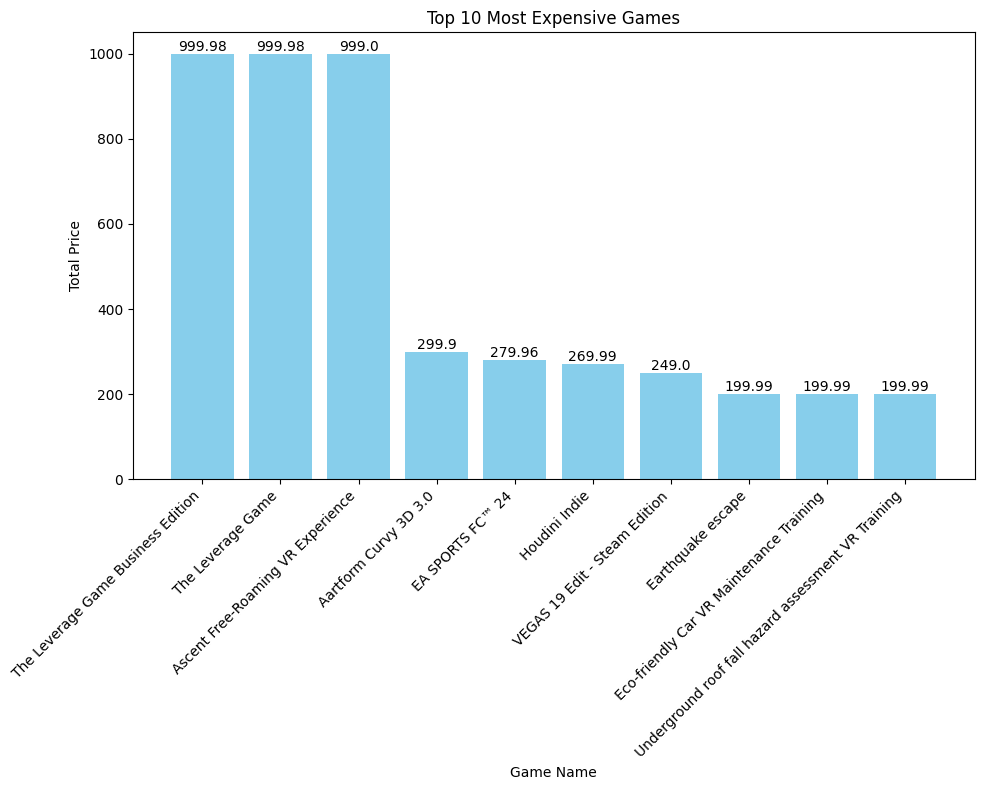

In [29]:
plt.figure(figsize=(10, 8))
bars = plt.bar(most_expensive_games['Name'], most_expensive_games['Price'], color='skyblue')
plt.title('Top 10 Most Expensive Games')
plt.xlabel('Game Name')
plt.ylabel('Total Price')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='black', size=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [69]:
most_expensive_games_3 = games[games['Price'] > 300].sort_values('Price', ascending=False).head(3)
view = ['Name', 'Price', 'OwnersClean' ]
print(most_expensive_games_3[view])

                                     Name   Price  OwnersClean
81926                   The Leverage Game  999.98      10000.0
82981  The Leverage Game Business Edition  999.98      10000.0
27000   Ascent Free-Roaming VR Experience  999.00      10000.0


The 3 most expensive games in the dataset have an estimated 10,000 downloads, would gamers be willing to pay more than $500 for a game?

#### Top 10 most frequent categories

A count is made of the frequency of the categories present in the 'Categories' column of the 'games' DataFrame, dividing the categories into lists using `str.split(',')` and then combining all the lists into a single list (`all_categories`) and finally creating a series of Pandas containing the counts for each category.

In [71]:
longest_row = games.loc[games['Categories'].apply(len).idxmax()]

print("The row with the most elements in the 'Categories' column is:")
print(longest_row['Name'])
print("Number of elements:", len(longest_row['Categories']))


The row with the most elements in the 'Categories' column is:
Animated Puzzles
Number of elements: 371


In [33]:
def count_categories(games):
    
    categories = games['Categories'].str.split(',')
    all_categories = [category for sublist in categories.dropna() for category in sublist]
    category_counts = pd.Series(all_categories).value_counts()
    
    return category_counts

category_counts = count_categories(games)
print(category_counts)

Single-player                        76421
Steam Achievements                   36804
Steam Cloud                          18817
Full controller support              15993
Multi-player                         15595
Partial Controller Support           10589
Steam Trading Cards                   9889
PvP                                   9846
Co-op                                 7817
Online PvP                            7036
Steam Leaderboards                    6815
Remote Play Together                  6169
Shared/Split Screen                   5683
Others                                4595
Online Co-op                          4466
Shared/Split Screen PvP               4078
Stats                                 3579
Shared/Split Screen Co-op             3189
Cross-Platform Multiplayer            2336
In-App Purchases                      2299
Remote Play on TV                     2166
Includes level editor                 1968
Steam Workshop                        1862
MMO        

Graph containing the 10 most common categories, where it is evident that people prefer games with the Single-Player category.

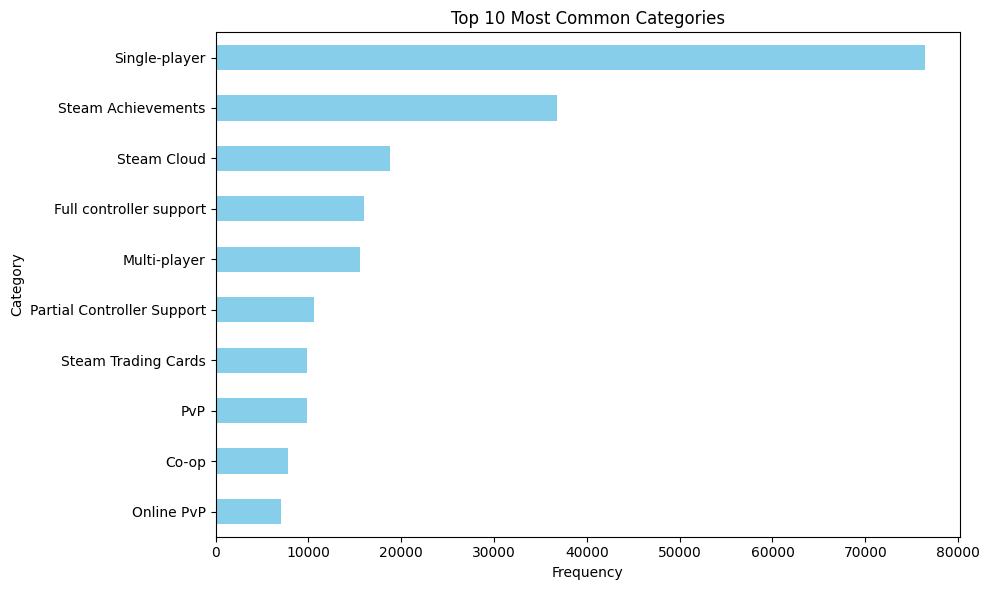

In [34]:
top_categories = category_counts.head(10)

plt.figure(figsize=(10, 6))
top_categories.plot(kind='barh', color='skyblue')
plt.title('Top 10 Most Common Categories')
plt.xlabel('Frequency')
plt.ylabel('Category')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


The line graph shows the trends of the five most used categories in the last 15 years of game releases, where Singler-player continues to lead, but this time it shows a decrease in the year 2024, since we only have information up to January of that year.

C:\Users\saale\AppData\Local\Temp\ipykernel_24404\1697274294.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_years = games_last_15_years[categories_df['Category'].str.contains(category_name)]
C:\Users\saale\AppData\Local\Temp\ipykernel_24404\1697274294.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_years = games_last_15_years[categories_df['Category'].str.contains(category_name)]
C:\Users\saale\AppData\Local\Temp\ipykernel_24404\1697274294.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_years = games_last_15_years[categories_df['Category'].str.contains(category_name)]
C:\Users\saale\AppData\Local\Temp\ipykernel_24404\1697274294.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_years = games_last_15_years[categories_df['Category'].str.contains(category_name)]
C:\Users\saale\AppData\Local\Temp\ipykernel_2440

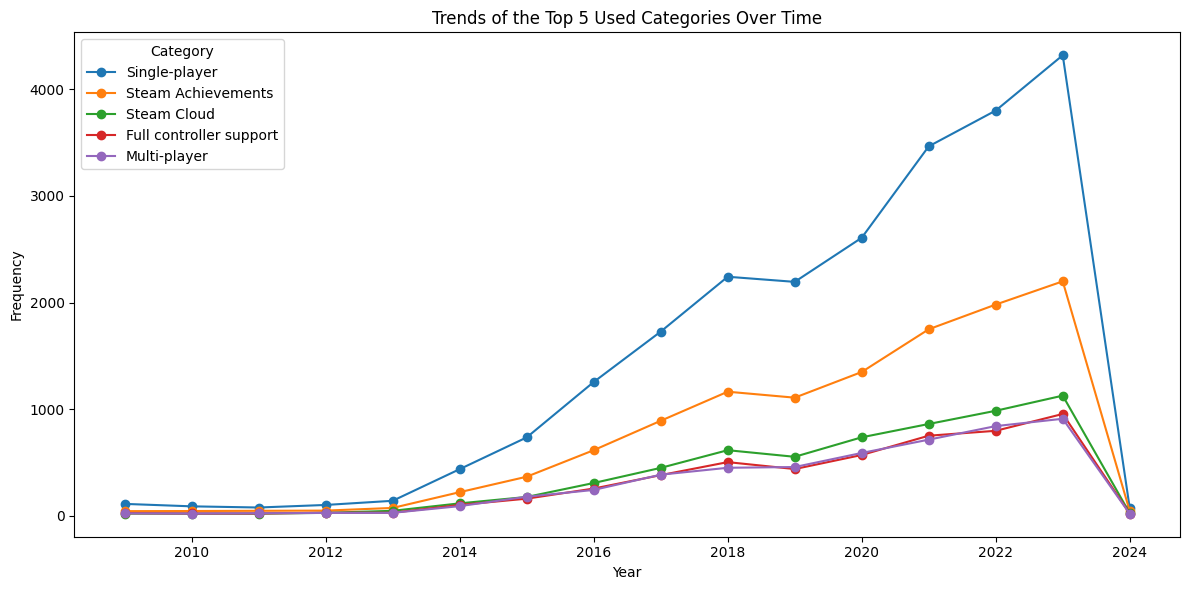

In [73]:
current_year = pd.Timestamp.now().year

games_last_15_years = games[games['ReleaseDate'].dt.year >= current_year - 15]

all_categories = [category.strip() for categories in games_last_15_years['Categories'].str.split(",") for category in categories]

categories_df = pd.DataFrame(all_categories, columns=['Category'])

category_counts = categories_df['Category'].value_counts()

top_5_categories = category_counts.head(5)

trends_top_5_categories = pd.DataFrame(index=range(current_year - 15, current_year + 1))

for category_name in top_5_categories.index:
    filtered_years = games_last_15_years[categories_df['Category'].str.contains(category_name)]
    trends_top_5_categories[category_name] = filtered_years['ReleaseDate'].dt.year.value_counts().sort_index()

plt.figure(figsize=(12, 6))
trends_top_5_categories.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Trends of the Top 5 Used Categories Over Time')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(title='Category', loc='upper left')
plt.tight_layout()
plt.show()

#### Top 10 most common Genres
 Horizontal bar chart representing the ten most common genres, where it is enviable that the most common genre is indie. 

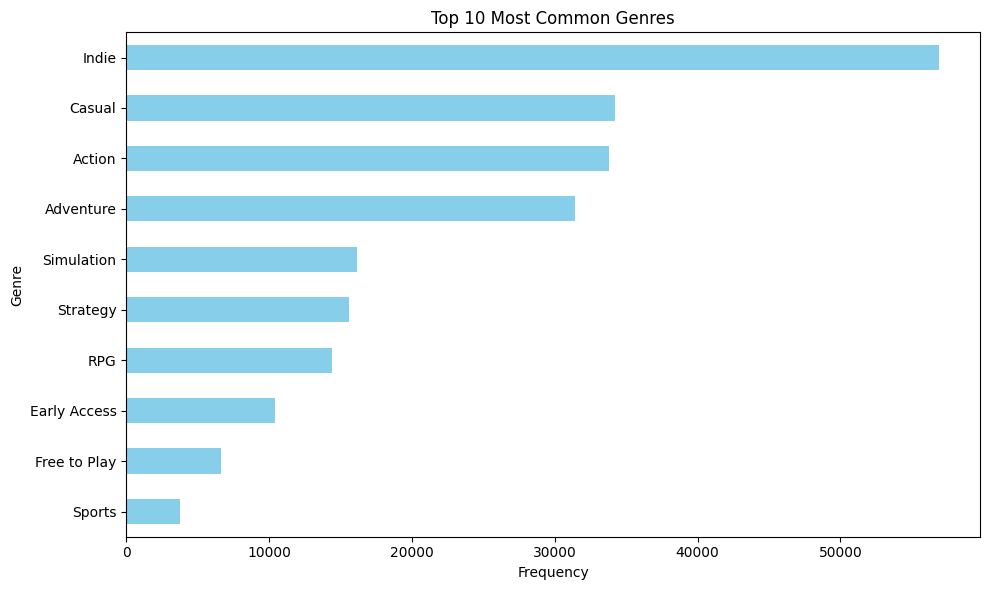

In [36]:
all_genres = [genre.strip() for genres in games['Genres'].str.split(",") for genre in genres]

genre_counts = pd.Series(all_genres).value_counts()

top_genres = genre_counts.head(10)

plt.figure(figsize=(10, 6))
top_genres.plot(kind='barh', color='skyblue')
plt.title('Top 10 Most Common Genres')
plt.xlabel('Frequency')
plt.ylabel('Genre')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()


## SupportedLanguages Column

In [74]:
longest_row_languages = games.loc[games['SupportedLanguages'].apply(len).idxmax()]

print("The row with the most elements in the 'SupportedLanguages' column is:")
print(longest_row_languages['Name'])
print("Number of elements:", len(longest_row_languages['SupportedLanguages']))


The row with the most elements in the 'SupportedLanguages' column is:
KaBoom!
Number of elements: 1008


SupportedLanguage is an array column, the game that supports the most languages is KaBoom! with 1008 adapted languages.

This process is responsible for preparing the data in the 'SupportedLanguages' column in a set of Steam games. It removes unnecessary characters and whitespace to ensure that the data is clean and ready for analysis.

In [38]:
def clean_supported_languages(games):
    games['SupportedLanguages'] = games['SupportedLanguages'].str.replace("]", '') \
        .str.replace("'", "") \
        .str.replace("[", "") \
        .str.replace("]", "") \
        .str.replace("&amp;lt;strong&amp;gt;&amp;lt;/strong&amp;gt;", "")   \
        .str.replace("b/b", "") \
        .str.replace("/b", "")  \
        .str.replace(" \\r\\n\\r\\nb/b ", "") \
        .str.replace("/b", "") \
        .str.replace("\\r\\nb/b", "") \
        .str.replace("\\r\\n", "") \
        .str.replace("#", "") \
        .str.replace("\r\\n\\r\\n", "")     \
        .str.replace("Russian\\r\\nEnglish\\r\\nSpanish - Spain\\r\\nFrench\\r\\nJapanese\\r\\nCzech", "")  \
        .str.replace("\r\\n", "") \
        .str.replace(" &amp;lt;br /&amp;gt;&amp;lt;br /&amp;gt; ", "") \
        .str.replace("RussianEnglishSpanish - SpainFrenchJapaneseCzech", "") \
        .str.lstrip(", ") \
        .str.strip()
    
    return games

games = clean_supported_languages(games)

This process extracts and counts the languages supported by Steam games. First, it splits the data in the 'SupportedLanguages' column into a tabular structure. Then, the resulting columns are merged and null values are removed. Next, the language names are cleaned, counted and stored in a DataFrame for further analysis.

In [39]:
df_languages = games['SupportedLanguages'].str.strip("[]").str.split(', ', expand=True)

df_melted = pd.melt(df_languages, value_name='Language').dropna()['Language'].str.strip("'")

language_counts = df_melted.value_counts().reset_index()

language_counts.columns = ['Language', 'Frequency']

language_counts

,Language,Frequency
0,English,78060
1,Simplified Chinese,19306
2,German,18652
3,French,18075
4,Russian,17383
...,...,...
110,"Hungarian,Polish",1
111,Japanese (all with full audio support),1
112,"English,German,Spanish - Spain,lang_français",1
113,Korean,1


This process generates a word cloud to visualize the most commonly used languages in Steam games, allowing a quick and visual understanding of the predominant languages in the dataset.

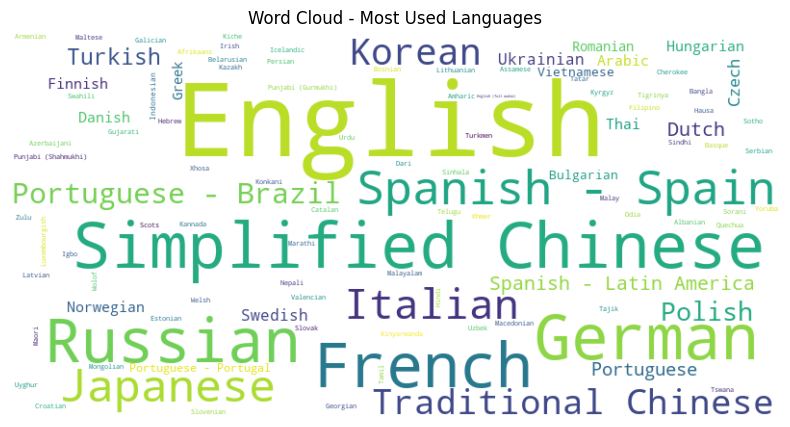

In [40]:
wordcloud_data = dict(zip(language_counts['Language'], language_counts['Frequency']))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Most Used Languages')
plt.show()


#### Pie chart of number of free or paid games

Classify games as paid or free in a new column ('FreeOrPaid') and provides a summary of the game count in each category.

In [41]:
# 'paid' if the game it is paid, 'free' if it is free

games['FreeOrPaid'] = games.apply(lambda row: 'paid' if row['Price'] > 0 else 'free', axis=1)

paid_and_free_count = games.groupby("FreeOrPaid").agg({
    "Name":"count"
}).reset_index()
paid_and_free_count

,FreeOrPaid,Name
0,free,16456
1,paid,68641


The pie chart shows that there are a large number of games that are paid games 80.7%. This predominance of paid games suggests that software developers and distribution platforms continue to rely on traditional business models.

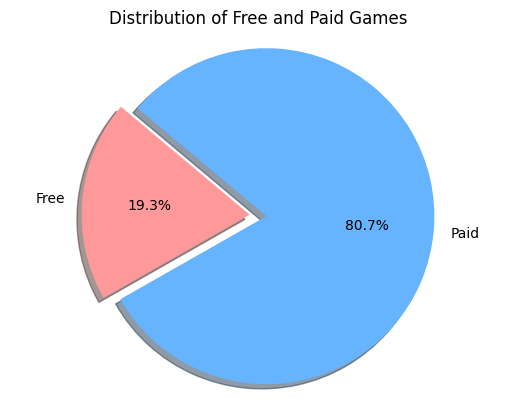

In [42]:

labels = ['Free', 'Paid']
sizes = paid_and_free_count['Name']
colors = ['#ff9999', '#66b3ff']  # Colors for 'Free' and 'Paid' categories
explode = (0.1, 0)  # Explode the first slice (Free)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures the chart is circular
plt.title('Distribution of Free and Paid Games')

plt.show()


#### Average Time

Transformation minute to hours (Average Playtime Forever)

In [43]:
games['AveragePlaytimeForever'] = games['AveragePlaytimeForever'] / 60

Graph of the top 10 Average Playtime Forever games, you can see that the game is Boom 3D which is a sound mixer.

d:\Universidad\5to Semestre\ETL\ProjectETL\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21103 (\N{CJK UNIFIED IDEOGRAPH-526F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Universidad\5to Semestre\ETL\ProjectETL\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20316 (\N{CJK UNIFIED IDEOGRAPH-4F5C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Universidad\5to Semestre\ETL\ProjectETL\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Universidad\5to Semestre\ETL\ProjectETL\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20043 (\N{CJK UNIFIED IDEOGRAPH-4E4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Universidad\5to Semestre\ETL\ProjectETL\venv\lib\site-packages\IPython\core\pylabtools.py:152: Us

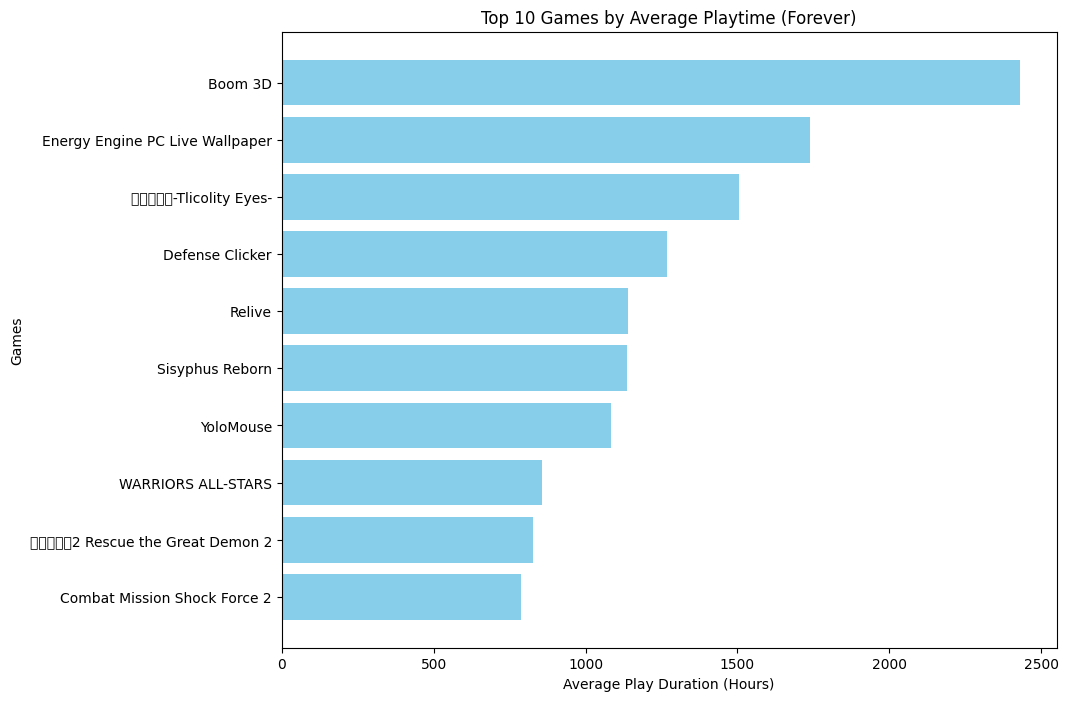

In [44]:
data_sorted = games.sort_values(by='AveragePlaytimeForever', ascending=False)

top_10_games = data_sorted.head(10)

plt.figure(figsize=(10, 8))
plt.barh(top_10_games['Name'], top_10_games['AveragePlaytimeForever'], color='skyblue')
plt.title('Top 10 Games by Average Playtime (Forever)')
plt.xlabel('Average Play Duration (Hours)')
plt.ylabel('Games')


plt.gca().invert_yaxis()  
plt.show()

Transformation minute to hours (Average Playtime Two Weeks)

In [45]:
games['AveragePlaytimeTwoWeeks'] = games['AveragePlaytimeTwoWeeks'] / 60

Graph of the top 10 games Average Playtime two weeks, in this case the information is about the 2 weeks of January that we have information and here it is evident that the most played game in that time is America's Army.

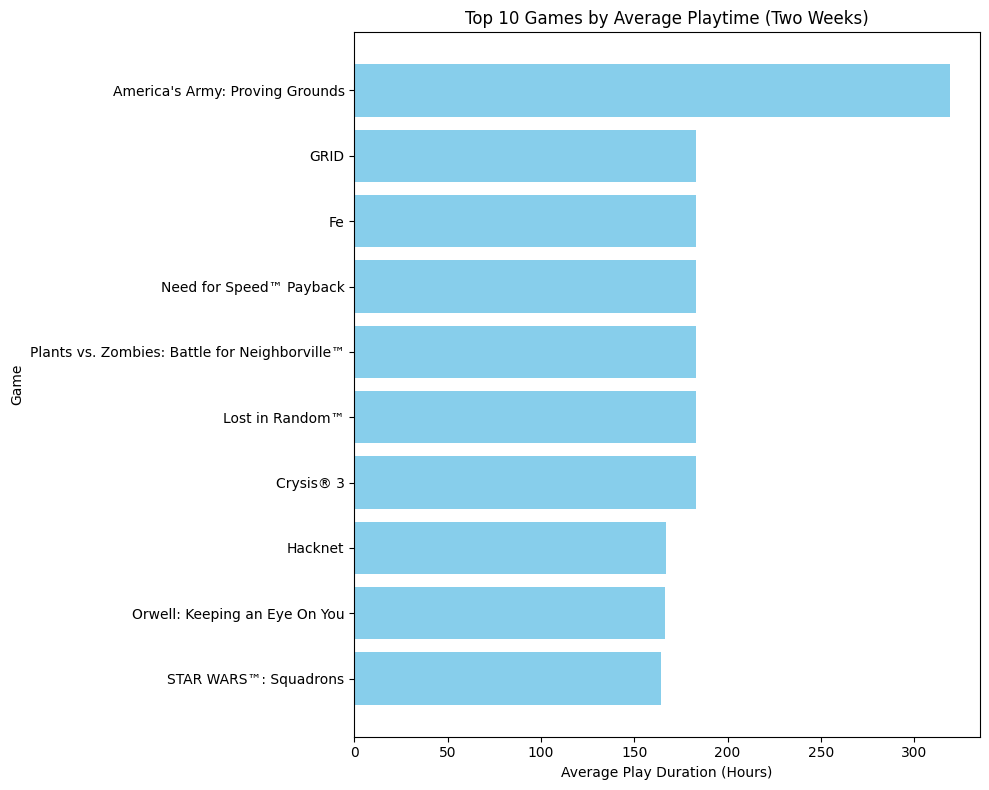

In [46]:
data_sorted = games.sort_values(by='AveragePlaytimeTwoWeeks', ascending=False)

top_10_games = data_sorted.head(10)

plt.figure(figsize=(10, 8))
plt.barh(top_10_games['Name'], top_10_games['AveragePlaytimeTwoWeeks'], color='skyblue')
plt.title('Top 10 Games by Average Playtime (Two Weeks)')
plt.xlabel('Average Play Duration (Hours)')
plt.ylabel('Game')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

#### Metracritic Score

Display 'Name', 'AveragePlaytimeForever' and 'MetacriticScore' information

In [47]:
view = ['Name','AveragePlaytimeForever','MetacriticScore']
data_sorted[view]

,Name,AveragePlaytimeForever,MetacriticScore
58274,America's Army: Proving Grounds,62.166667,0
33102,GRID,13.350000,0
53505,Fe,102.050000,0
2074,Need for Speed™ Payback,35.800000,62
36188,Plants vs. Zombies: Battle for Neighborville™,18.500000,77
...,...,...,...
28756,Rip Them Off,0.000000,0
28755,World CHAMPIONS: Decathlon,0.000000,0
28754,Goliath,1.300000,57
28753,Dungeon Dreams,0.000000,0


Display the information with the name of the game and the number of positive votes for the top 15 games according to the rating of positive votes.

In [48]:
sorted_by_positive = games.sort_values(by='Positive', ascending=False)

top_positive = sorted_by_positive.head(15)

top_positive_df = pd.DataFrame({
    'Game Name': top_positive['Name'],
    'Positive Votes': top_positive['Positive']
})

top_positive_df.reset_index(drop=True, inplace=True)

top_positive_df

,Game Name,Positive Votes
0,Counter-Strike: Global Offensive,5764420
1,Dota 2,1477153
2,Grand Theft Auto V,1171197
3,PUBG: BATTLEGROUNDS,1154655
4,Terraria,964983
5,Tom Clancy's Rainbow Six® Siege,929372
6,Team Fortress 2,823693
7,Garry's Mod,822326
8,Rust,703687
9,Left 4 Dead 2,619457


Graph showing the vs. between positive and negative games, where more games have a positive rating.Graph showing the vs. between positive and negative games, where more games have a positive rating.

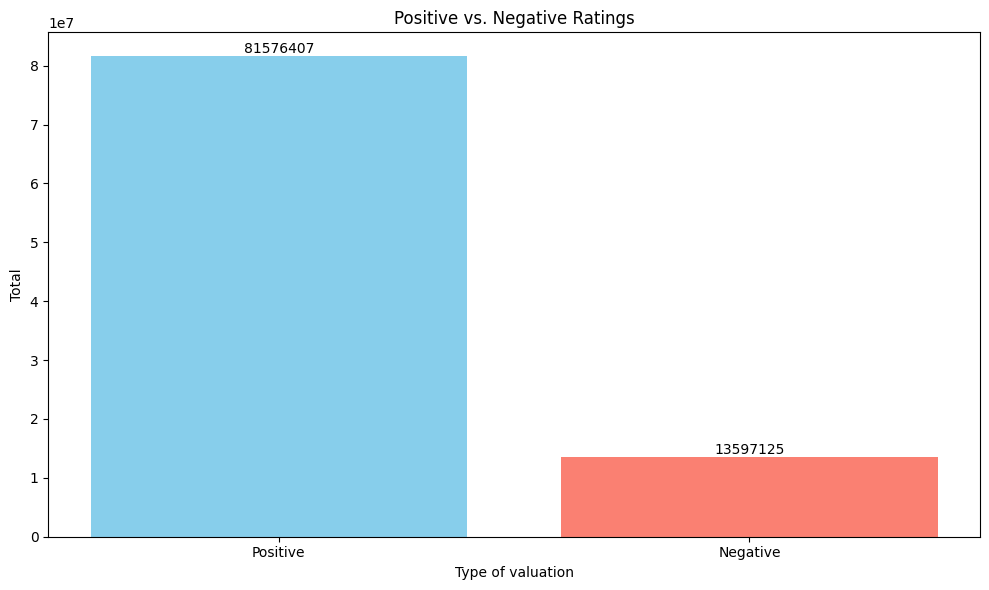

In [49]:
total_positive = games['Positive'].sum()
total_negative = games['Negative'].sum()

totals = pd.DataFrame({'Valoration': ['Positive', 'Negative'], 'Total': [total_positive, total_negative]})

plt.figure(figsize=(10, 6))
bars = plt.bar(totals['Valoration'], totals['Total'], color=['skyblue', 'salmon'])
plt.title('Positive vs. Negative Ratings')
plt.xlabel('Type of valuation')
plt.ylabel('Total')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar etiquetas de texto encima de las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.grid(False)
plt.show()

This process generates a word cloud to visualize the most common game tags. First, the 'Tags' column is divided into individual tags, which are then counted to determine the frequency of each tag. Next, the WordCloud library is used to create the word cloud based on these frequencies, providing a visual representation of the most popular tags in the game dataset.

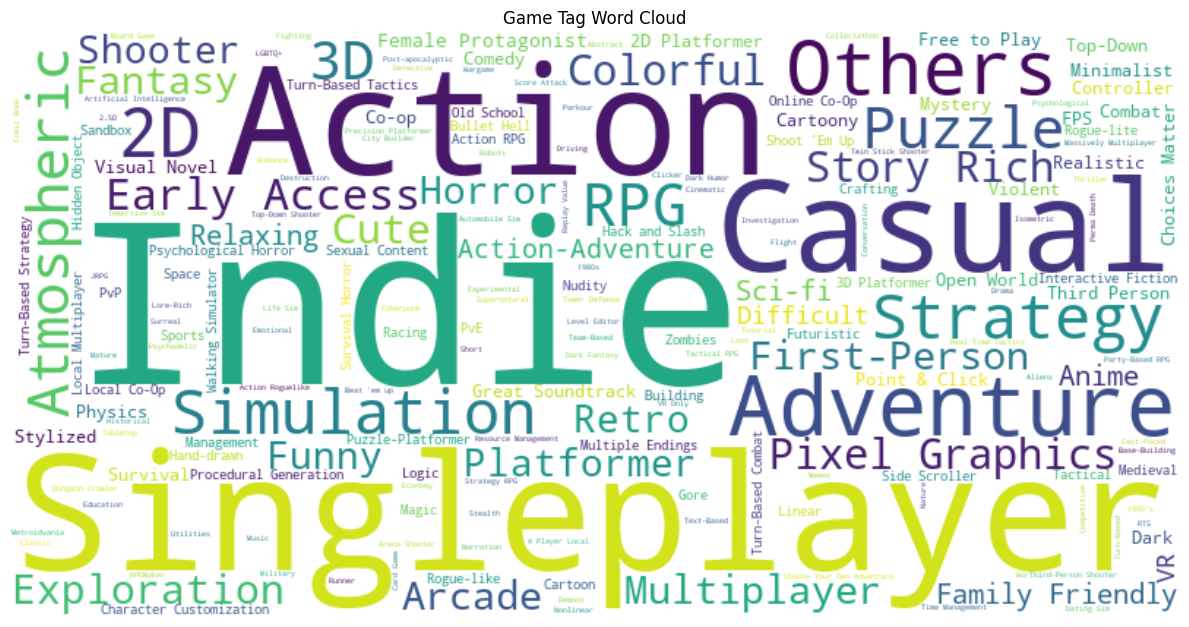

In [50]:
tags_individual = games['Tags'].str.split(',').explode().str.strip()

tag_counts = tags_individual.value_counts()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_counts)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Game Tag Word Cloud')
plt.axis('off')  
plt.tight_layout()
plt.show()

This analysis identifies the most popular games based on the 'Positive' column and extracts the tags associated with these games. It then counts the frequency of each tag and selects the 20 most common tags. These tags are displayed in a horizontal bar chart, providing insight into the most prevalent tags in the most popular games.

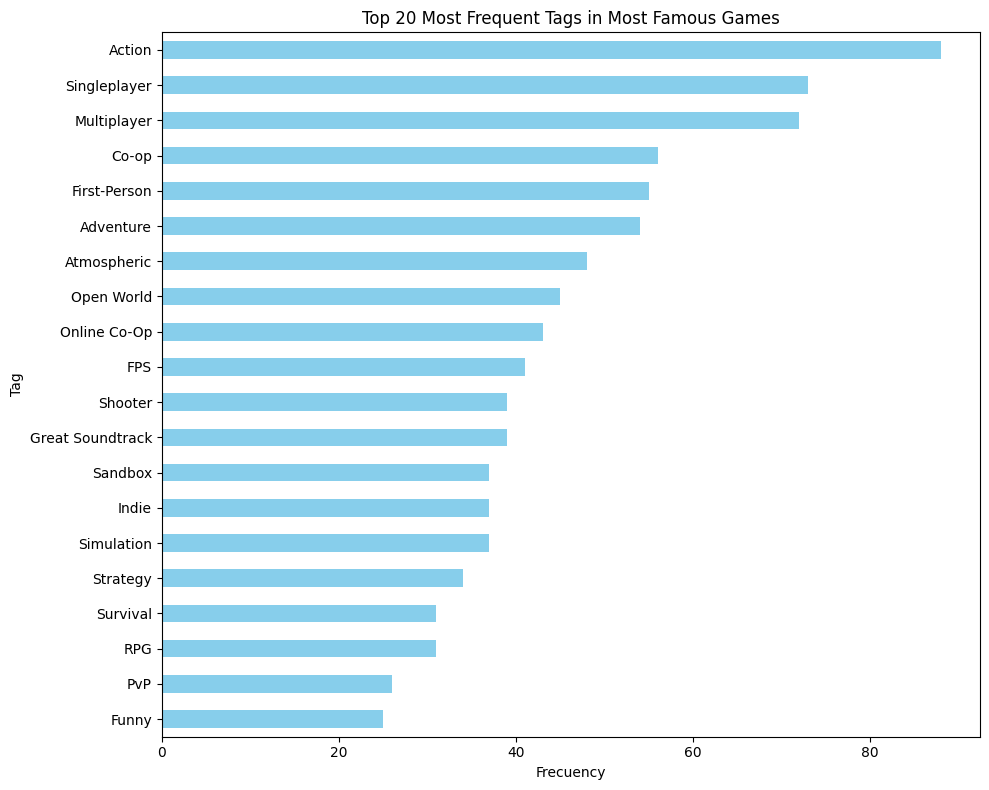

In [51]:
top_games = games.nlargest(100, 'Positive')

tags_individual = top_games['Tags'].str.split(',').explode().str.strip()

tag_counts = tags_individual.value_counts()

top_tags = tag_counts.head(20)

plt.figure(figsize=(10, 8))
top_tags.plot(kind='barh', color='skyblue')
plt.title('Top 20 Most Frequent Tags in Most Famous Games')
plt.xlabel('Frecuency')
plt.ylabel('Tag')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

This analysis examines the tags in games, counts the frequency of each, and displays the 6 most common tags in a pie chart. This provides a quick overview of the most popular tags in the games.

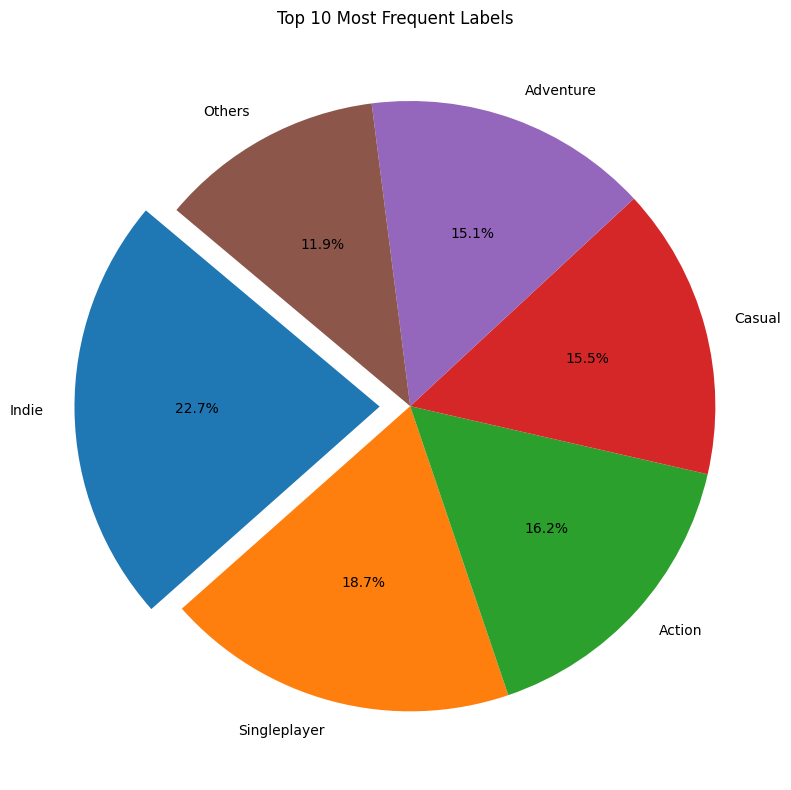

In [52]:
tags_individual = games['Tags'].str.split(',').explode().str.strip()

tag_counts = tags_individual.value_counts()

top_tags = tag_counts.head(6)

plt.figure(figsize=(8, 8))
explode = (0.1, 0, 0, 0, 0, 0)  
plt.pie(top_tags, labels=top_tags.index, explode=explode, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Most Frequent Labels')
plt.axis('equal') 
plt.tight_layout()
plt.show()

#### Years and PeakCCU

Graph showing the PeakCCU and the Release Date where it can be seen that there was a peak in two years, one in 2013 and the other in 2023

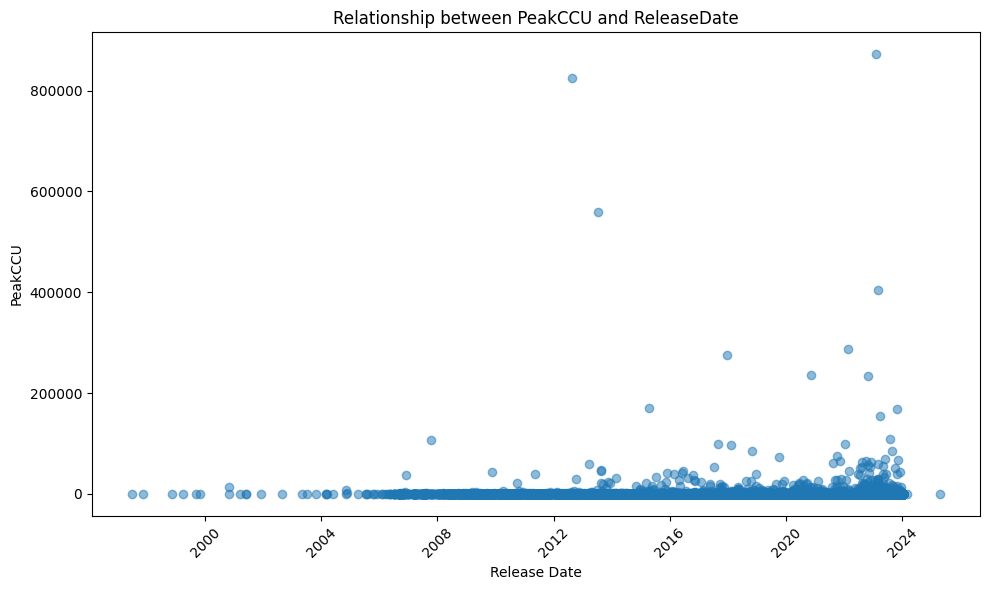

In [53]:
plt.figure(figsize=(10, 6))

plt.scatter(games['ReleaseDate'], games['PeakCCU'], alpha=0.5)
plt.title('Relationship between PeakCCU and ReleaseDate')
plt.xlabel('Release Date')
plt.ylabel('PeakCCU')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Upload finally dataset into database

It ensures that the table structure in the database is up to date and aligned with the changes made to the data during the cleaning and exploratory analysis process.

In [54]:
if inspect(connection).has_table('steam_games'):
    try:
        SteamGames.__table__.drop(connection)
        SteamGames.__table__.create(connection)
        print("Table created successfully.")
    except Exception as e:
        print(f"Error creating table: {e}")
else:
    try:
        SteamGames.__table__.create(connection)
        print("Table created successfully.")
    except Exception as e:
        print(f"Error creating table: {e}")

Table created successfully.


The cleaned and parsed data is loaded into the 'steam_games' table of the database.

In [55]:
try:

    games.to_sql('steam_games', connection, if_exists='replace', index=False)
    print("Data uploaded")

except Exception as e:
    print(f"Error: {e}")

finally:
    session.close()

Data uploaded


Additionally save the data in a CSV file, this will be saved in the data folder.

In [ ]:
games.to_csv('../../data/final_games.csv', index=False, encoding='utf-8')

**Here ends the exploratory data analysis of our dataset, you must continue with notebook 003.**